# COMP0189: Applied Artificial Intelligence
## Week 2 (pipelines and model selection)

### After this week you will be able to ...
- Streamline preprocessing steps in advanced way (Pipeline and ColumnTransformer)
- Perform model selection and model assessment using different partitions of the data
- Use different cross-validation strategies 
- Use GridSearchCV 

### Acknowledgements
- https://archive.ics.uci.edu/ml/datasets/adult
- https://scikit-learn.org/stable/modules/compose.html
- https://scikit-learn.org/stable/model_selection.html

## Preparation

Before we begin, we make sure that all necessary libraries are installed.

In [1]:
%pip install scikit-learn==1.6.1 matplotlib seaborn pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations

We can now load the same adult income dataset used in last week's lab.

In [ ]:
import pandas as pd
import numpy as np
import numpy.typing as npt
from sklearn.model_selection import train_test_split

def load_adult(data_path: str) -> pd.DataFrame:
    # Load dataset with specifying ' ?' as missing values
    names = ['age','workclass','fnlwgt','education',
            'marital-status','occupation','relationship','race','sex',
            'capital-gain','capital-loss','hours-per-week','native-country',
            'y']
    df = pd.read_csv(data_path, delimiter=',', names=names, na_values=' ?')

    for col_name in df.columns:
        if df[col_name].dtype == object:  # Checking for object type (string in pandas)
            df[col_name] = df[col_name].apply(lambda x: x.strip() if isinstance(x, str) else x)
    
    return df

def train_test_split_df(df: pd.DataFrame, test_ratio=0.3, target_col="y", random_state=42) -> tuple[pd.DataFrame, npt.NDArray[np.bool_], pd.DataFrame, npt.NDArray[np.bool_]]:
    # Separate features and target
    df_data = df.drop(columns=[target_col])
    df_target = df[target_col]

    # Randomized train-test split with a fixed seed
    train_X_df, test_X_df, train_y_df, test_y_df = train_test_split(
        df_data, df_target, test_size=test_ratio, random_state=random_state
    )

    # Convert target variable to binary (assuming it's categorical with ">50K" and others)
    train_y = (train_y_df == ">50K").to_numpy(dtype=np.bool_)
    test_y = (test_y_df == ">50K").to_numpy(dtype=np.bool_)

    return train_X_df, train_y, test_X_df, test_y

adult_df = load_adult("adult.data")
train_X, train_y, test_X, test_y = train_test_split_df(adult_df)

train_X

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
19749,34,Self-emp-not-inc,56460,HS-grad,Married-civ-spouse,Farming-fishing,Wife,White,Female,0,2179,12,United-States
1216,48,Self-emp-not-inc,243631,Some-college,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688,0,40,United-States
27962,23,State-gov,56402,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,30,United-States
23077,56,Local-gov,255406,HS-grad,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
10180,17,Private,297246,11th,Never-married,Priv-house-serv,Own-child,White,Female,0,0,9,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,47,Private,359461,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
5390,31,Private,147215,12th,Divorced,Other-service,Unmarried,White,Female,0,0,21,United-States
860,18,Private,216284,11th,Never-married,Adm-clerical,Own-child,White,Female,0,0,20,United-States
15795,50,Self-emp-not-inc,54261,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,84,United-States


## Part 1: Pipelines

This part of the lab focuses on streamlining preprocessing and model training with scikit-learn. We will reimplement the last exercise of last week's lab using a more advanced way of controlling how to process data.

### Task 1.1: Writing a Pipeline

[Pipelines](https://scikit-learn.org/stable/modules/compose.html) are a feature of scikit-learn for combining multiple processing steps together. This is quite useful, for example, when we want to apply a sequence of many pre-processing steps to the same data.

In this exercise, we extract the `age` feature from the dataset and add some missing values for the sake of exercise. Use a `Pipeline` to impute the missing values and scale the feature.

> You can use the same imputation and scaling operations seen in the previous lab

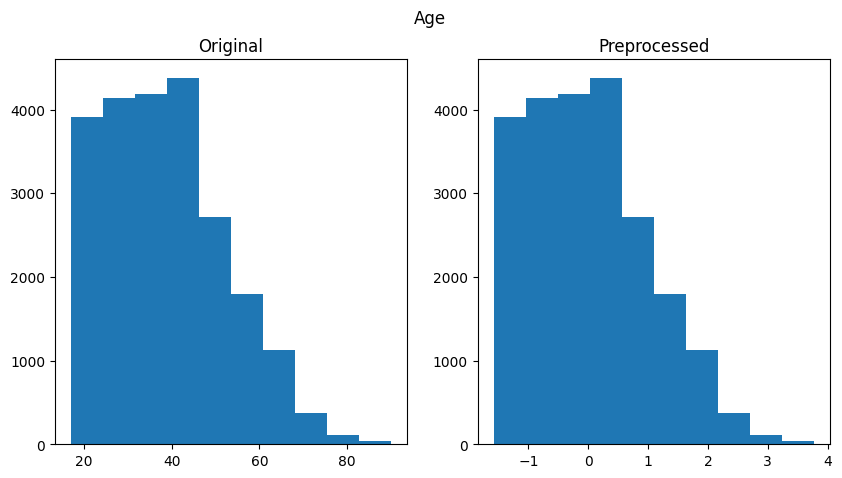

Original first entry: nan
Preprocessed first entry: -0.0


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function for visualising preprocessing results
def check_results(feature_name: str, age_original: npt.NDArray, age_preprocessed: npt.NDArray) -> None:
    # Plot the data distribution before and after preprocessing
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(feature_name)
    ax[0].hist(age_original)
    ax[0].set_title("Original")
    ax[1].hist(age_preprocessed)
    ax[1].set_title("Preprocessed")
    plt.show()

    # Print the value of the first entry before and after preprocessing
    print(f"Original first entry: {age_original.ravel()[0]}")
    print(f"Preprocessed first entry: {round(age_preprocessed.ravel()[0], 2)}")

# Set the first row of all columns to NaN to simulate missing values
train_X.iloc[0] = np.nan
test_X.iloc[0] = np.nan

# Extract the age feature as a Numpy array
age_original = train_X["age"].to_numpy(dtype=np.float32).reshape((len(train_X["age"]), 1))

# Create a Pipeline to preprocess the age feature
impute_and_scale = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),  # You can replace with KNNImputer if needed
        ("scaler", StandardScaler()),
    ]
)

# Fit the pipeline and check results
age_preprocessed = impute_and_scale.fit_transform(age_original)
check_results("Age", age_original, age_preprocessed)

Notice that we can now easily reapply the fitted preprocessing steps to the testing data:

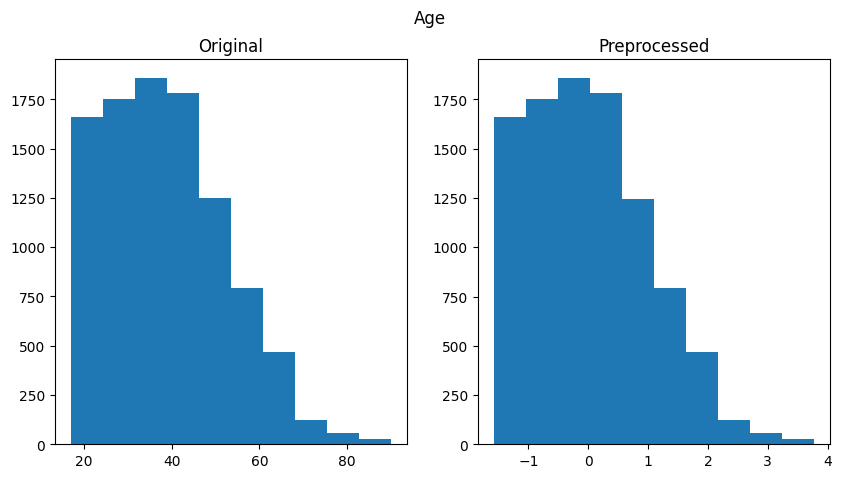

Original first entry: nan
Preprocessed first entry: -0.0


In [5]:
# Extract the age feature from the testing data
age_original_test = test_X["age"].to_numpy(dtype=np.float32).reshape((len(test_X["age"]), 1))

# Apply the fitted pipeline
age_preprocessed_test = impute_and_scale.transform(age_original_test)

check_results("Age", age_original_test, age_preprocessed_test)

### Task 1.2: Deciding which Pipeline to run

In the previous task, we only applied our pipeline to the `age` feature, which we extracted and passed to the fitting function. However, the same imputation and scaling strategy would be suitable for most numerical features in the dataset. By contrast, it would not make sense for categorical features (since they cannot be scaled and cannot be imputed by taking the mean). So we'd like to use the same pipeline for all numerical features, while leaving out categorical ones.

Scikit-learn offers a [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data) feature for this purpose. For this exercise, write a ColumnTransformer which takes the whole training dataset, selects only the numerical features and applies the pipeline from the previous cell.

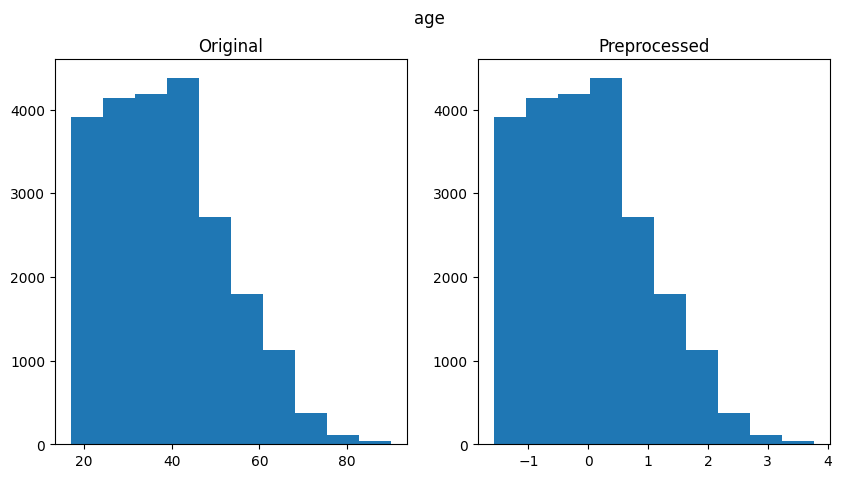

Original first entry: nan
Preprocessed first entry: -0.0


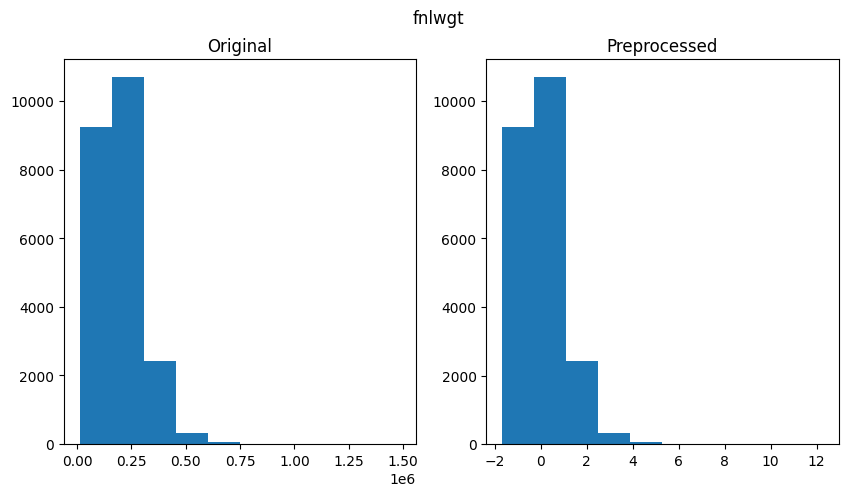

Original first entry: nan
Preprocessed first entry: -0.0


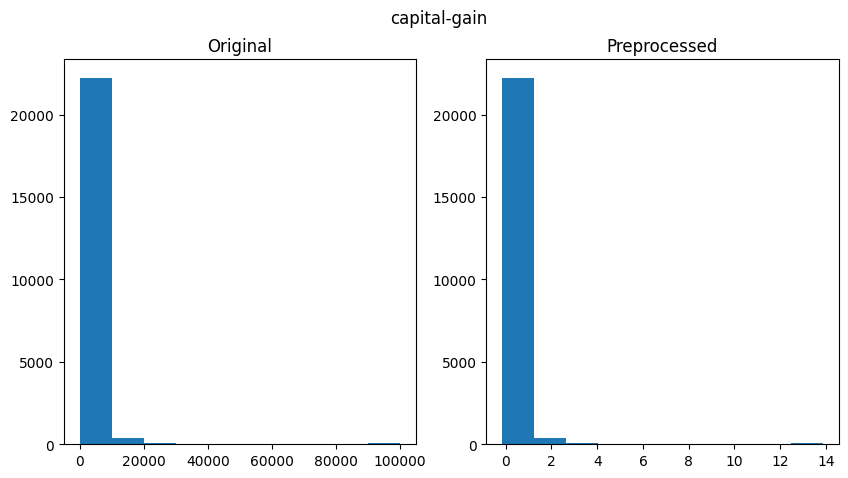

Original first entry: nan
Preprocessed first entry: 0.0


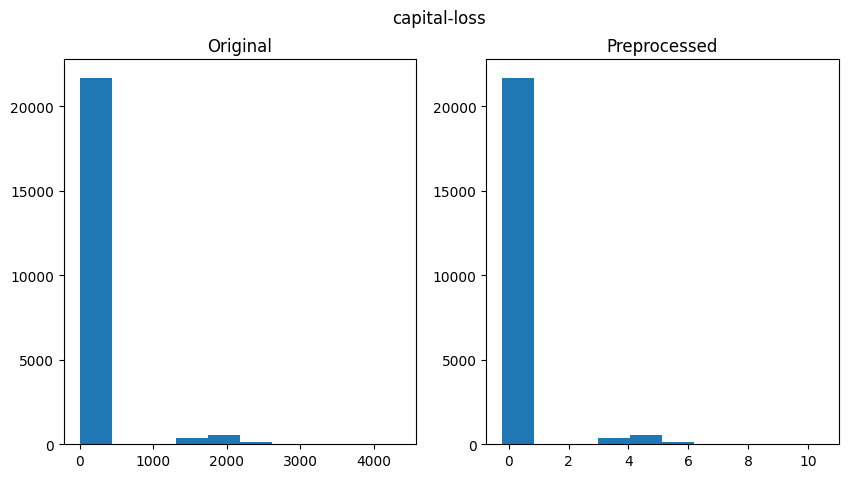

Original first entry: nan
Preprocessed first entry: 0.0


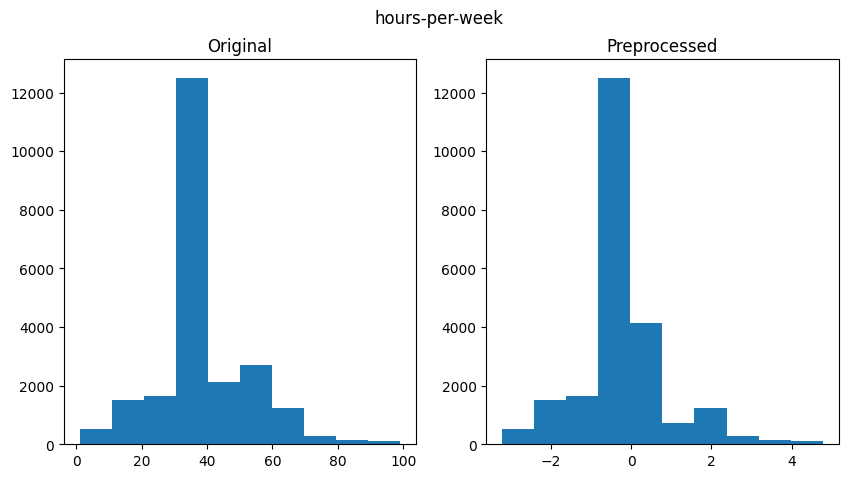

Original first entry: nan
Preprocessed first entry: 0.0


In [6]:
from sklearn.compose import ColumnTransformer

# List the features to process
non_categorical_features = [
    "age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week"
]

# Apply the pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("non_categorical_transformer", impute_and_scale, non_categorical_features),
    ]
)

# Fit the pipeline and check results
non_categorical_preprocessed = preprocessor.fit_transform(train_X)

for i, feature in enumerate(non_categorical_features):
    check_results(feature, train_X[[feature]].to_numpy(), non_categorical_preprocessed[:, i])

Applying the fitted pipeline to the testing data is now even easier, as we don't need to manually extract the features we want to preprocess.

Use the pipeline to transform the testing data.

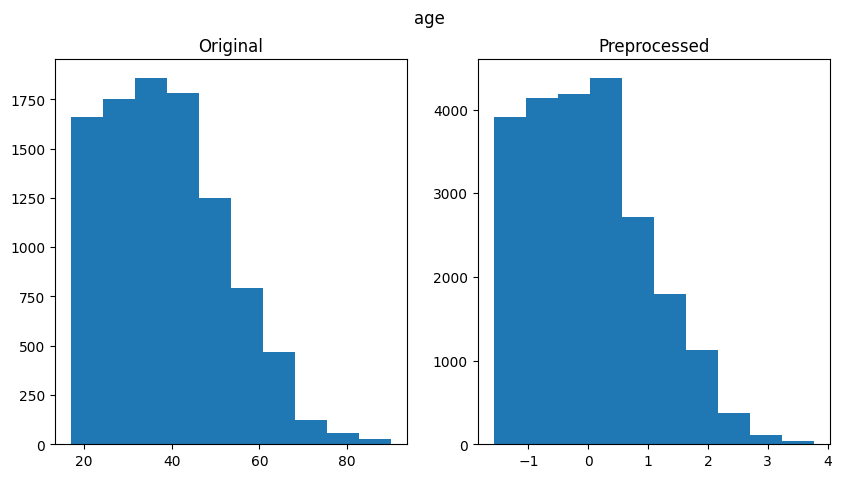

Original first entry: nan
Preprocessed first entry: -0.0


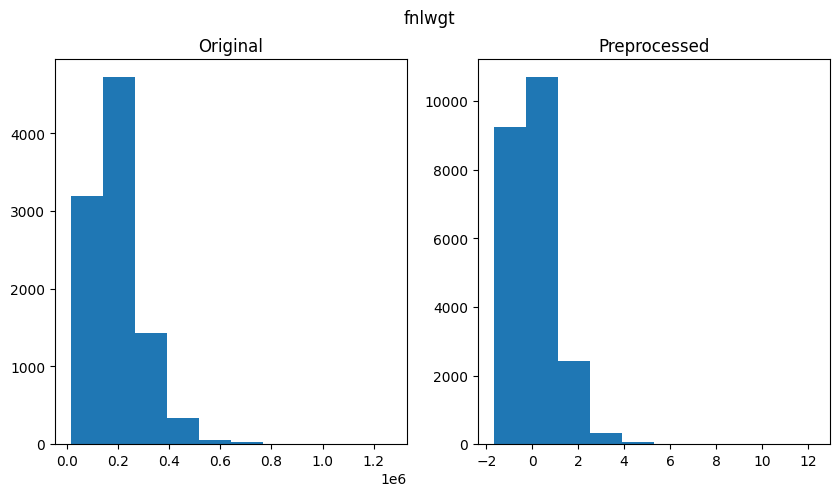

Original first entry: nan
Preprocessed first entry: -0.0


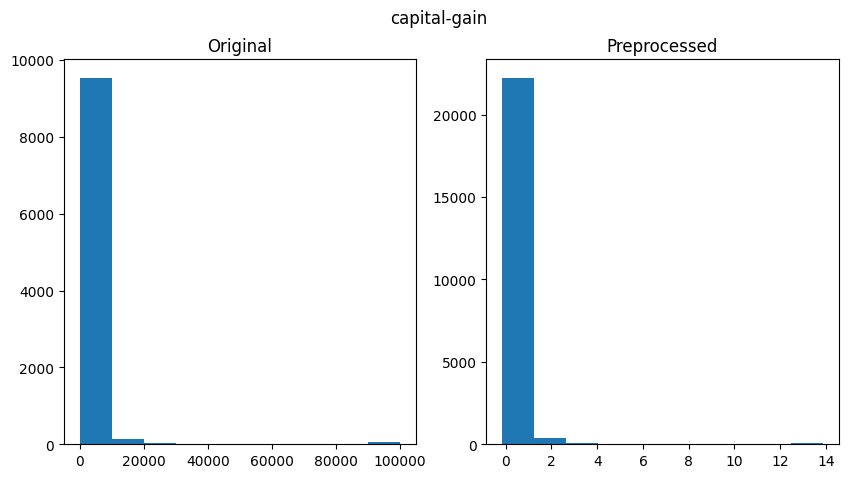

Original first entry: nan
Preprocessed first entry: 0.0


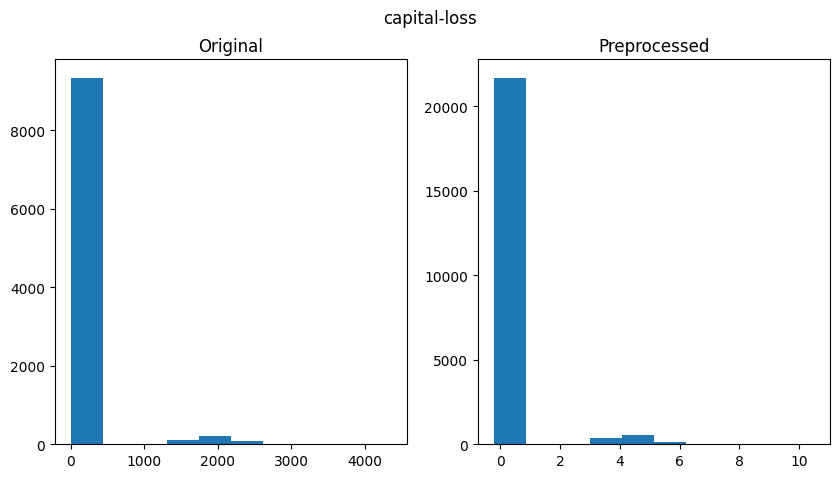

Original first entry: nan
Preprocessed first entry: 0.0


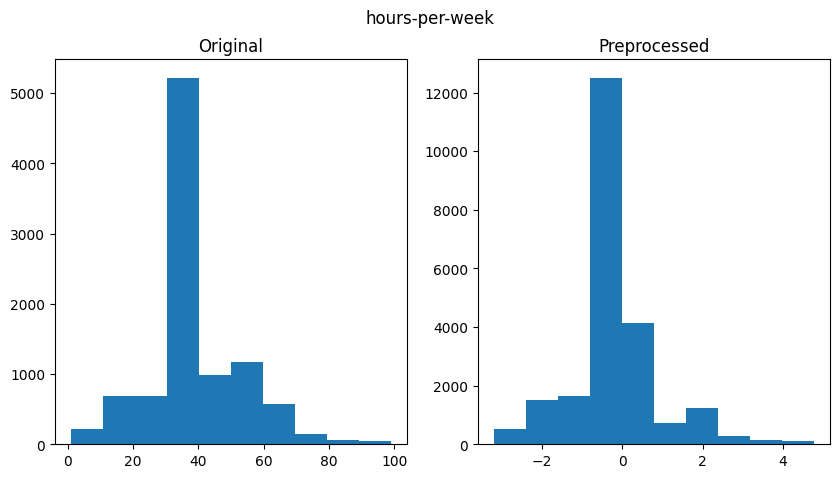

Original first entry: nan
Preprocessed first entry: 0.0


In [7]:
non_categorical_preprocessed = preprocessor.transform(test_X)

for i, feature in enumerate(non_categorical_features):
    check_results(feature, test_X[[feature]].to_numpy(), non_categorical_preprocessed[:, i])

### Task 1.3: Preprocessing the whole dataset

Now expand the code you've written so far to process all features in the dataset. Apply whichever steps seem reasonable depending on the feature types.

> You can reuse the same steps you used in last week's notebook, but use Pipelines to join them

In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Define the preprocessing for non-categorical features
non_categorical_features = [
    "age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week"
]

non_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),  # You can replace with KNNImputer if needed
        ("scaler", StandardScaler()),
    ]
)

# Define the preprocessing for nominal categorical features
nominal_categorical_features = [
    "workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"
]

nominal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")),
    ]
)

# Define the preprocessing for ordinal categorical features education
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th',
                   '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Prof-school',
                   'Bachelors', 'Masters', 'Doctorate']

ordinal_categorical_features = ["education"]

ordinal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[education_order],)),
    ]
)

# Assign different preprocessors to different features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", non_categorical_transformer, non_categorical_features),
        ("nominal_cat", nominal_categorical_transformer, nominal_categorical_features),
        ("ordinal_cat", ordinal_categorical_transformer, ordinal_categorical_features),
    ]
)

# Fit the preprocessing pipeline
preprocessor.fit_transform(train_X)

array([[-5.20724585e-16, -2.75533455e-16,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  8.00000000e+00],
       [ 6.91210188e-01,  5.10604899e-01,  9.29735791e-01, ...,
         0.00000000e+00,  0.00000000e+00,  9.00000000e+00],
       [-1.14092657e+00, -1.26194024e+00, -1.46355480e-01, ...,
         0.00000000e+00,  0.00000000e+00,  9.00000000e+00],
       ...,
       [-1.50735392e+00,  2.51703809e-01, -1.46355480e-01, ...,
         0.00000000e+00,  0.00000000e+00,  6.00000000e+00],
       [ 8.37781128e-01, -1.28220964e+00, -1.46355480e-01, ...,
         0.00000000e+00,  0.00000000e+00,  8.00000000e+00],
       [-3.34786395e-01, -5.87407619e-01, -1.46355480e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.30000000e+01]],
      shape=(22792, 82))

### Task 1.4: Joining preprocessing and model training

Note that any estimator can be part of a Pipeline - even models. Try to create a new pipeline which combines the `preprocessing_pipeline` from the previous task with an SVM classifier. The resulting pipeline will be able to both fit the preprocessing pipeline and train the model in a single step.

> You can use `make_pipeline` to add steps to an existing pipeline

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

whole_pipeline = make_pipeline(preprocessor, SVC(random_state=42))
whole_pipeline.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('nominal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown=...
                                                   'native-country']),
                                                 ('ordinal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8th',
                                                                                               '9th',
                                                                                               '10th',
                                                                                               '11th',
                                                                                               '12th',
                                                                                               'HS-grad',
                                                                                               'Some-college',
                                                                                               'Assoc-voc',
                                                                                               'Assoc-acdm',
                                                                                               'Prof-school',
                                                                                               'Bachelors',
                                                                                               'Masters',
                                                                                               'Doctorate']]))]),
                                                  ['education'])])),
                ('svc', SVC(random_state=42))])

Now use the fitted pipeline to preprocess the test data and predict results in a single step.

In [10]:
from sklearn.metrics import accuracy_score

pred_y = whole_pipeline.predict(test_X)
accuracy_score(test_y, pred_y)

0.8522878493192753

## Part 2: Cross Validation (CV)

scikit-learn provides a nice visualisation of various cross validation methods.
This notebook focuses on different cross validation strategies and how to account for data structure during cross-validation.


Visit: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#visualizing-cross-validation-behavior-in-scikit-learn

![kfold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_006.png)
![stra-kfold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_003.png)
![group-kfold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_004.png)
![stra-group-kfold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

In [19]:
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
    GridSearchCV,
)
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np


def perform_cv(X_train: pd.DataFrame, y_train: npt.NDArray, pipeline: Pipeline, cv_strategy, groups=None) -> tuple[float, float]:
    ''' 
    Return the mean accuracy and its standard deviation
    when fitting the given pipeline across several cross-validation folds,
    according to the given CV strategy
    '''

    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv_strategy,
        groups=groups,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    return scores.mean(), scores.std()

### Task 5: Cross-validation for hyperparameter optimisation
Now apply cross-validation to the train set for optimizing the models hyperparameters. After identifying the best hyperparameter, measure the performance on the test data by training the models on the training data using the optimal hyperparameter. Print the average cross-validation score, the best cross-validation score, the best hyperparameter and the test-score.

 - Is there a difference between the average cross-validation score, the best cross-validation score and the test-score?

Note: remember that the pre-processing steps, including data centering and scaling should be embedded in the CV.

In [18]:
############## Step 1: Cross-Validation for Hyperparameter Tuning ##############
# Define hyperparameter search space
C_values = [0.1, 0.5, 1.0]  # Regularization parameter
kernel_values = ['linear', 'rbf']  # Kernel types
cv_strategy = KFold(n_splits=2)  # 2-fold cross-validation

# Try all combinations and store results
svc_cv_results = []
for C in C_values:
    for kernel in kernel_values:
        # Create pipeline with preprocessing and model
        svc_model = make_pipeline(preprocessor, SVC(random_state=42, kernel=kernel, C=C))
        # Get cross-validation scores
        mean_score, std_score = perform_cv(train_X, train_y, svc_model, cv_strategy)
        svc_cv_results.append((C, kernel, mean_score, std_score))
        print(f"SVC (C={C}, kernel={kernel}): {mean_score:.3f} (+/- {std_score:.3f})")

############## Step 2: Train Final Model with Best Parameters ##############
# Find best parameters based on CV results
best_svc_params = max(svc_cv_results, key=lambda x: x[2])
print(f"\nBest parameters: C={best_svc_params[0]}, kernel={best_svc_params[1]}")

# Create and train final model with best parameters
best_svc = make_pipeline(preprocessor, SVC(
    C=best_svc_params[0],
    kernel=best_svc_params[1],
    random_state=42
))
best_svc.fit(train_X, train_y)

############## Step 3: Evaluate on Test Set ##############
cv_scores = np.array([score for _, _, score, _ in svc_cv_results])
test_score = best_svc.score(test_X, test_y)
print(f"\nTest set accuracy: {test_score:.3f}")
print(f"Best CV score: {np.max(cv_scores):.3f}")
print(f"Average CV score: {np.mean(cv_scores):.3f}")

/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.1, kernel=linear): 0.850 (+/- 0.001)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.1, kernel=rbf): 0.833 (+/- 0.004)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.5, kernel=linear): 0.851 (+/- 0.000)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.5, kernel=rbf): 0.846 (+/- 0.003)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=1.0, kernel=linear): 0.851 (+/- 0.000)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=1.0, kernel=rbf): 0.848 (+/- 0.002)

Best parameters: C=1.0, kernel=linear

Test set accuracy: 0.852
Best CV score: 0.851
Average CV score: 0.846


#### Task 5-1: Plotting model performance
Plot the model performance (mean accuracy and SD) for different hyper-parameter values.
- How does the accuracy vary as function of the hyperparameter?

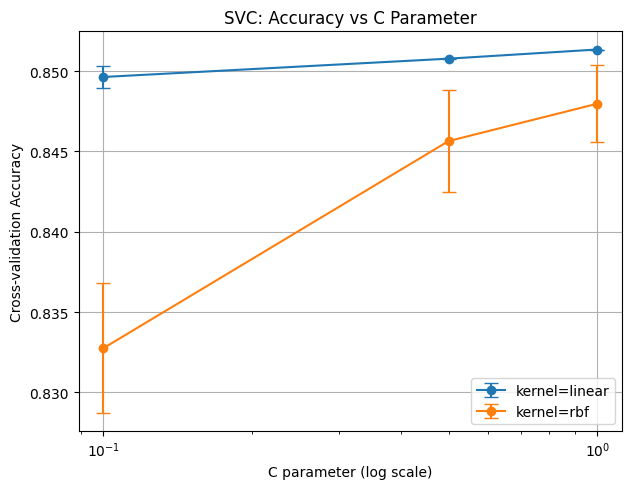


Best Parameters:
SVC:
C=1.0, kernel=linear
Accuracy: 0.851 ± 0.000


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
#plt.style.use('seaborn')

# 1. SVC Visualization
plt.figure(figsize=(12, 5))

# Create subplot for SVC
plt.subplot(1, 2, 1)
svc_results_df = pd.DataFrame(svc_cv_results, 
                            columns=['C', 'kernel', 'accuracy', 'std'])

# Plot for different kernels
for kernel in kernel_values:
    kernel_data = svc_results_df[svc_results_df['kernel'] == kernel]
    plt.errorbar(kernel_data['C'], kernel_data['accuracy'], 
                yerr=kernel_data['std'], 
                fmt='o-', 
                label=f'kernel={kernel}',
                capsize=5)

plt.xscale('log')
plt.xlabel('C parameter (log scale)')
plt.ylabel('Cross-validation Accuracy')
plt.title('SVC: Accuracy vs C Parameter')
plt.legend()
plt.grid(True)



# Adjust layout and display
plt.tight_layout()
plt.show()

# Print best parameters and their corresponding accuracies
print("\nBest Parameters:")
print("SVC:")
best_svc_result = svc_results_df.loc[svc_results_df['accuracy'].idxmax()]
print(f"C={best_svc_result['C']}, kernel={best_svc_result['kernel']}")
print(f"Accuracy: {best_svc_result['accuracy']:.3f} ± {best_svc_result['std']:.3f}")



### Task 6: Group Stratified cross-validation
Repeat task 5 using groups stratified CV with k=5 and sex as the group variable. Centre and scale the data before training the models. Print the average cross-validation score, the best cross-validation score, the best hyperparameter and the test-score.

- Did the performances changes with the group stratified CV?

In [33]:
cv_strategy = StratifiedGroupKFold(n_splits=2,)  # 2-fold Stratified cross-validation

# Try all combinations and store results
svc_cv_results = []
for C in C_values:
    for kernel in kernel_values:
        # Create pipeline with preprocessing and model
        svc_model = make_pipeline(preprocessor, SVC(random_state=42, kernel=kernel, C=C))

        # Create group labels
        group_labels = (train_X["sex"] == "Male").to_numpy(dtype=np.int16)

        # Get cross-validation scores
        mean_score, std_score = perform_cv(train_X, train_y, svc_model, cv_strategy, groups=group_labels)
        svc_cv_results.append((C, kernel, mean_score, std_score))
        print(f"SVC (C={C}, kernel={kernel}): {mean_score:.3f} (+/- {std_score:.3f})")

# Find best parameters based on CV results
best_svc_params = max(svc_cv_results, key=lambda x: x[2])
print(f"\nBest parameters: C={best_svc_params[0]}, kernel={best_svc_params[1]}")

# Create and train final model with best parameters
best_svc = make_pipeline(preprocessor, SVC(
    C=best_svc_params[0],
    kernel=best_svc_params[1],
    random_state=42
))
best_svc.fit(train_X, train_y)

# Evaluate
cv_scores = np.array([score for _, _, score, _ in svc_cv_results])
test_score = best_svc.score(test_X, test_y)
print(f"\nTest set accuracy: {test_score:.3f}")
print(f"Best CV score: {np.max(cv_scores):.3f}")
print(f"Average CV score: {np.mean(cv_scores):.3f}")

/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.1, kernel=linear): 0.853 (+/- 0.067)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.1, kernel=rbf): 0.813 (+/- 0.095)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.5, kernel=linear): 0.859 (+/- 0.060)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=0.5, kernel=rbf): 0.838 (+/- 0.084)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=1.0, kernel=linear): 0.860 (+/- 0.060)


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVC (C=1.0, kernel=rbf): 0.846 (+/- 0.080)

Best parameters: C=1.0, kernel=linear

Test set accuracy: 0.852
Best CV score: 0.860
Average CV score: 0.845


### Task 7: Using Scikit's GridSearchCV
So far, we manually calculated the accuracy score of each cross-validation fold using the `perform_cv` function. This allowed us to show how cross-validation works in detail, but in practice we'd probably use the utilities provided by Scikit instead. One such utility is [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), a Scikit class to automatically perform hyperparameter optimisation by calculating the CV score for a "grid" of hyperparameters.

Here, rewrite the hyperparameter optimisation code so that it uses GridSearchCV to search the hyperparameters grid and train the final model.

See also the [user guide](https://scikit-learn.org/stable/modules/grid_search.html) for hyperparameter optimisation with Scikit.

In [44]:
############## Step 1: Define Model and Pipeline ##############
# Create a pipeline that combines preprocessing and SVC model
# This ensures preprocessing steps are properly included in cross-validation
model_svc = make_pipeline(preprocessor, SVC(random_state=42))

############## Step 2: Define Hyperparameter Search Space ##############
# Specify the parameters to search
# Note: 'svc__' prefix is required because SVC is part of a pipeline
param_grid = {
    'svc__C': [0.1, 1, 10],          # Regularization parameter
    'svc__kernel': ['linear', 'rbf']  # Kernel types
}

############## Step 3: Setup Cross-validation Strategy ##############
# Use StratifiedKFold to maintain the same ratio of samples for each class
cv = StratifiedKFold(n_splits=2)

############## Step 4: Configure Grid Search ##############
# Initialize GridSearchCV with all parameters
grid_search = GridSearchCV(
    estimator=model_svc,              # Pipeline to use
    param_grid=param_grid,            # Parameter combinations to try
    n_jobs=-1,                        # Number of parallel jobs, here we use as many as processor cores
    cv=cv,                            # Cross-validation strategy
    scoring="accuracy",               # Metric to optimize
    error_score=0,                    # Score to assign if error occurs
    verbose=1,                        # Print progress
    refit=True                        # After finding the best hyperparameters, refit the model on the whole training data
)

############## Step 5: Perform Grid Search and fit the final model ##############
# Fit the grid search to find best parameters
# This step performs cross-validation for all parameter combinations
grid_result = grid_search.fit(train_X, train_y)

############## Step 6: Make Predictions ##############
# Apply model to test set
y_hat_svc = grid_result.predict(test_X)

############## Step 7: Print Results ##############
print("\nSVC Results:")
print("Average cross-validation score: ", grid_result.cv_results_['mean_test_score'].mean())
print("Best cross-validation score: ", grid_result.best_score_)
print("Best hyperparameters: ", grid_result.best_params_)
print("Test score: ", accuracy_score(y_hat_svc, test_y))


Fitting 2 folds for each of 6 candidates, totalling 12 fits


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will b


SVC Results:
Average cross-validation score:  0.847424534924535
Best cross-validation score:  0.8518778518778518
Best hyperparameters:  {'svc__C': 10, 'svc__kernel': 'rbf'}
Test score:  0.8548469648889344


### Task 8: Nested cross-validation
Now implement a nested CV for optimize the models’ hyper-parameters and assessing the models’ performance (with k=5 for the inner and outer loop). The inner loop should optimize the models’ hyper-parameters and the outer loop should assess the models’ performance.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

############## Step 1: Initialize Setup ##############
# Initialize empty list to store scores from each outer fold
score = []

# Define base model with pipeline
model_svc = make_pipeline(preprocessor, SVC(random_state=42))

# Define hyperparameter search space
param_grid = {
    'svc__C': [0.1, 1],              # Regularization parameters to try
    'svc__kernel': ['linear', 'rbf']  # Kernel types to try
}

############## Step 2: Nested Cross-Validation ##############
inner_cv = KFold(n_splits=5)
outer_cv = KFold(n_splits=5)

# Outer loop of nested CV
for i, (train_index, test_index) in enumerate(outer_cv.split(adult_df)):
    # Split data for this outer fold
    train_data = adult_df.iloc[train_index].drop(["y"], axis=1)
    test_data = adult_df.iloc[test_index].drop(["y"], axis=1)
    
    # Prepare target variables (convert to binary)
    train_data_y = np.where(adult_df.iloc[train_index]["y"] == ">50K", 1, 0)
    test_data_y = np.where(adult_df.iloc[test_index]["y"] == ">50K", 1, 0)
    
    ############## Step 3: Inner Cross-Validation ##############
    # Configure GridSearchCV for inner loop
    grid_search = GridSearchCV(
        estimator=model_svc,
        param_grid=param_grid,
        n_jobs=-1,                    # Number of parallel jobs
        cv=inner_cv,                  # Inner CV strategy
        scoring="accuracy",           # Evaluation metric
        error_score=0,
        verbose=1,
        refit=True                    # After finding the best hyperparameters, refit the model on the whole training data
    )
    
    # Perform grid search on training data
    grid_result = grid_search.fit(train_data, train_data_y)

    ############## Step 5: Evaluation ##############
    # Make predictions on test set
    y_hat_svc = grid_result.predict(test_data)
    
    # Calculate and store accuracy for this fold
    score.append(accuracy_score(y_hat_svc, test_data_y))

############## Step 6: Results Summary ##############
print("\nNested CV Results for SVC:")
print(f"Mean Accuracy: {np.mean(score):.3f} (+/- {np.std(score):.3f})")
print(f"Individual Fold Scores: {[f'{s:.3f}' for s in score]}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will b

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will b

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will b

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cosimo/repos/COMP0189-practical-2025/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will b


Nested CV Results for SVC:
Mean Accuracy: 0.849 (+/- 0.002)
Individual Fold Scores: ['0.845', '0.848', '0.852', '0.851', '0.849']
